# 📈 Vector Autoregression (VAR) Model - Visualizations

This notebook runs and visualizes the VAR model for Brent Oil multivariate analysis.

**VAR Model Features:**
- Captures interdependencies between oil prices and macro variables (GDP, CPI, USD Index, Interest Rates)
- Forecasts multiple variables simultaneously
- Impulse Response Functions (IRF) show shock propagation
- Granger causality tests reveal predictive relationships

In [1]:
# Setup
import sys
sys.path.append('../services')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

from db_service import load_market_data

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams["font.size"] = 11

print("✅ Setup complete!")

✅ Setup complete!


## 1️⃣ Load and Prepare Data

In [2]:
# Load data from database
df = load_market_data()

# Select variables for VAR
var_cols = ['price', 'gdp', 'cpi', 'usd_index', 'interest_rate']
data = df[var_cols].dropna()

# Take log of price for better stationarity
data['log_price'] = np.log(data['price'])
var_data = data[['log_price', 'gdp', 'cpi', 'usd_index', 'interest_rate']]

print(f"📊 VAR Dataset:")
print(f"   Shape: {var_data.shape}")
print(f"   Date Range: {var_data.index[0]} to {var_data.index[-1]}")
print(f"   Variables: {list(var_data.columns)}")
print(f"\n{var_data.head()}")

INFO:db_service:✅ Loaded 4615 rows from market_data.


📊 VAR Dataset:
   Shape: (4571, 5)
   Date Range: 2007-10-01 00:00:00 to 2026-02-13 00:00:00
   Variables: ['log_price', 'gdp', 'cpi', 'usd_index', 'interest_rate']

            log_price       gdp     cpi  usd_index  interest_rate
date                                                             
2007-10-01   4.352083  14715.06  209.19      90.88           4.56
2007-10-02   4.348728  14715.06  209.19      91.12           4.54
2007-10-03   4.348728  14715.06  209.19      91.10           4.55
2007-10-04   4.369068  14715.06  209.19      91.16           4.54
2007-10-05   4.368181  14715.06  209.19      90.74           4.65


## 2️⃣ Stationarity Tests (Augmented Dickey-Fuller)

In [3]:
# Test stationarity for each variable
print("\n" + "="*70)
print("  AUGMENTED DICKEY-FULLER STATIONARITY TESTS")
print("="*70)

adf_results = []
for col in var_data.columns:
    result = adfuller(var_data[col].dropna(), autolag='AIC')
    adf_results.append({
        'Variable': col,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Stationary': 'Yes' if result[1] < 0.05 else 'No'
    })
    print(f"{col:15} | ADF: {result[0]:8.4f} | p-value: {result[1]:.4f} | {adf_results[-1]['Stationary']}")

print("="*70)

adf_df = pd.DataFrame(adf_results)

# If non-stationary, difference the data
if (adf_df['p-value'] > 0.05).any():
    print("\n⚠️ Some variables are non-stationary. Differencing...")
    var_data_diff = var_data.diff().dropna()
    print(f"   New shape after differencing: {var_data_diff.shape}")
else:
    var_data_diff = var_data
    print("\n✅ All variables are stationary!")


  AUGMENTED DICKEY-FULLER STATIONARITY TESTS
log_price       | ADF:  -3.1205 | p-value: 0.0251 | Yes
gdp             | ADF:   1.2038 | p-value: 0.9960 | No
cpi             | ADF:   2.5784 | p-value: 0.9991 | No
usd_index       | ADF:  -1.4831 | p-value: 0.5419 | No
interest_rate   | ADF:  -1.9845 | p-value: 0.2934 | No

⚠️ Some variables are non-stationary. Differencing...
   New shape after differencing: (4570, 5)


## 3️⃣ Optimal Lag Selection

In [4]:
# Fit VAR to determine optimal lag
model = VAR(var_data_diff)
lag_order = model.select_order(maxlags=15)

print("\n" + "="*70)
print("  LAG ORDER SELECTION CRITERIA")
print("="*70)
print(lag_order.summary())
print("="*70)

# Use AIC for lag selection
optimal_lag = lag_order.aic
print(f"\n✅ Selected Lag Order (AIC): {optimal_lag}")


  LAG ORDER SELECTION CRITERIA
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -9.406     -9.399*   8.220e-05     -9.404*
1       -9.410      -9.368   8.187e-05      -9.396
2      -9.412*      -9.334  8.175e-05*      -9.385
3       -9.409      -9.296   8.202e-05      -9.369
4       -9.407      -9.259   8.218e-05      -9.355
5       -9.400      -9.217   8.270e-05      -9.336
6       -9.401      -9.183   8.262e-05      -9.324
7       -9.395      -9.141   8.311e-05      -9.306
8       -9.394      -9.105   8.318e-05      -9.293
9       -9.395      -9.071   8.312e-05      -9.281
10      -9.390      -9.031   8.353e-05      -9.264
11      -9.391      -8.996   8.351e-05      -9.251
12      -9.392      -8.962   8.337e-05      -9.241
13      -9.393      -8.927   8.334e-05      -9.229
14      -9.387      -8.886   8.380e-05      -9.211
15      -9.385      -8.849   8.396e-05      -9.197

## 4️⃣ Fit VAR Model

In [5]:
# Fit VAR model with optimal lag
var_model = model.fit(optimal_lag)

print("\n" + "="*70)
print("  VAR MODEL SUMMARY")
print("="*70)
print(var_model.summary())
print("="*70)


  VAR MODEL SUMMARY
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 14, Feb, 2026
Time:                     15:07:07
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -9.34328
Nobs:                     4568.00    HQIC:                  -9.39342
Log likelihood:          -10836.8    FPE:                8.10322e-05
AIC:                     -9.42066    Det(Omega_mle):     8.00635e-05
--------------------------------------------------------------------
Results for equation log_price
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.000033         0.000353           -0.093           0.926
L1.log_price            -0.021627         0.015859           -1.364           0.173
L1.gdp                 

## 5️⃣ Granger Causality Tests

In [6]:
# Granger causality: Does X help predict Y?
print("\n" + "="*70)
print("  GRANGER CAUSALITY TESTS (Does X → Y?)")
print("="*70)

causality_matrix = pd.DataFrame(
    index=var_data_diff.columns,
    columns=var_data_diff.columns
)

for col_y in var_data_diff.columns:
    for col_x in var_data_diff.columns:
        if col_x == col_y:
            causality_matrix.loc[col_x, col_y] = '-'
            continue
        
        # Test if col_x Granger-causes col_y
        test_data = var_data_diff[[col_y, col_x]]
        try:
            result = grangercausalitytests(test_data, maxlag=optimal_lag, verbose=False)
            p_value = result[optimal_lag][0]['ssr_ftest'][1]
            
            if p_value < 0.01:
                causality_matrix.loc[col_x, col_y] = '***'
            elif p_value < 0.05:
                causality_matrix.loc[col_x, col_y] = '**'
            elif p_value < 0.10:
                causality_matrix.loc[col_x, col_y] = '*'
            else:
                causality_matrix.loc[col_x, col_y] = ''
        except:
            causality_matrix.loc[col_x, col_y] = 'N/A'

print("\nCausality Matrix (X → Y):")
print("*** p<0.01, ** p<0.05, * p<0.10")
print(causality_matrix)
print("="*70)


  GRANGER CAUSALITY TESTS (Does X → Y?)

Causality Matrix (X → Y):
*** p<0.01, ** p<0.05, * p<0.10
              log_price gdp cpi usd_index interest_rate
log_price             -   *           ***              
gdp                 ***   -             *              
cpi                   *       -                        
usd_index                     *         -              
interest_rate                                         -


## 6️⃣ Impulse Response Functions (IRF)

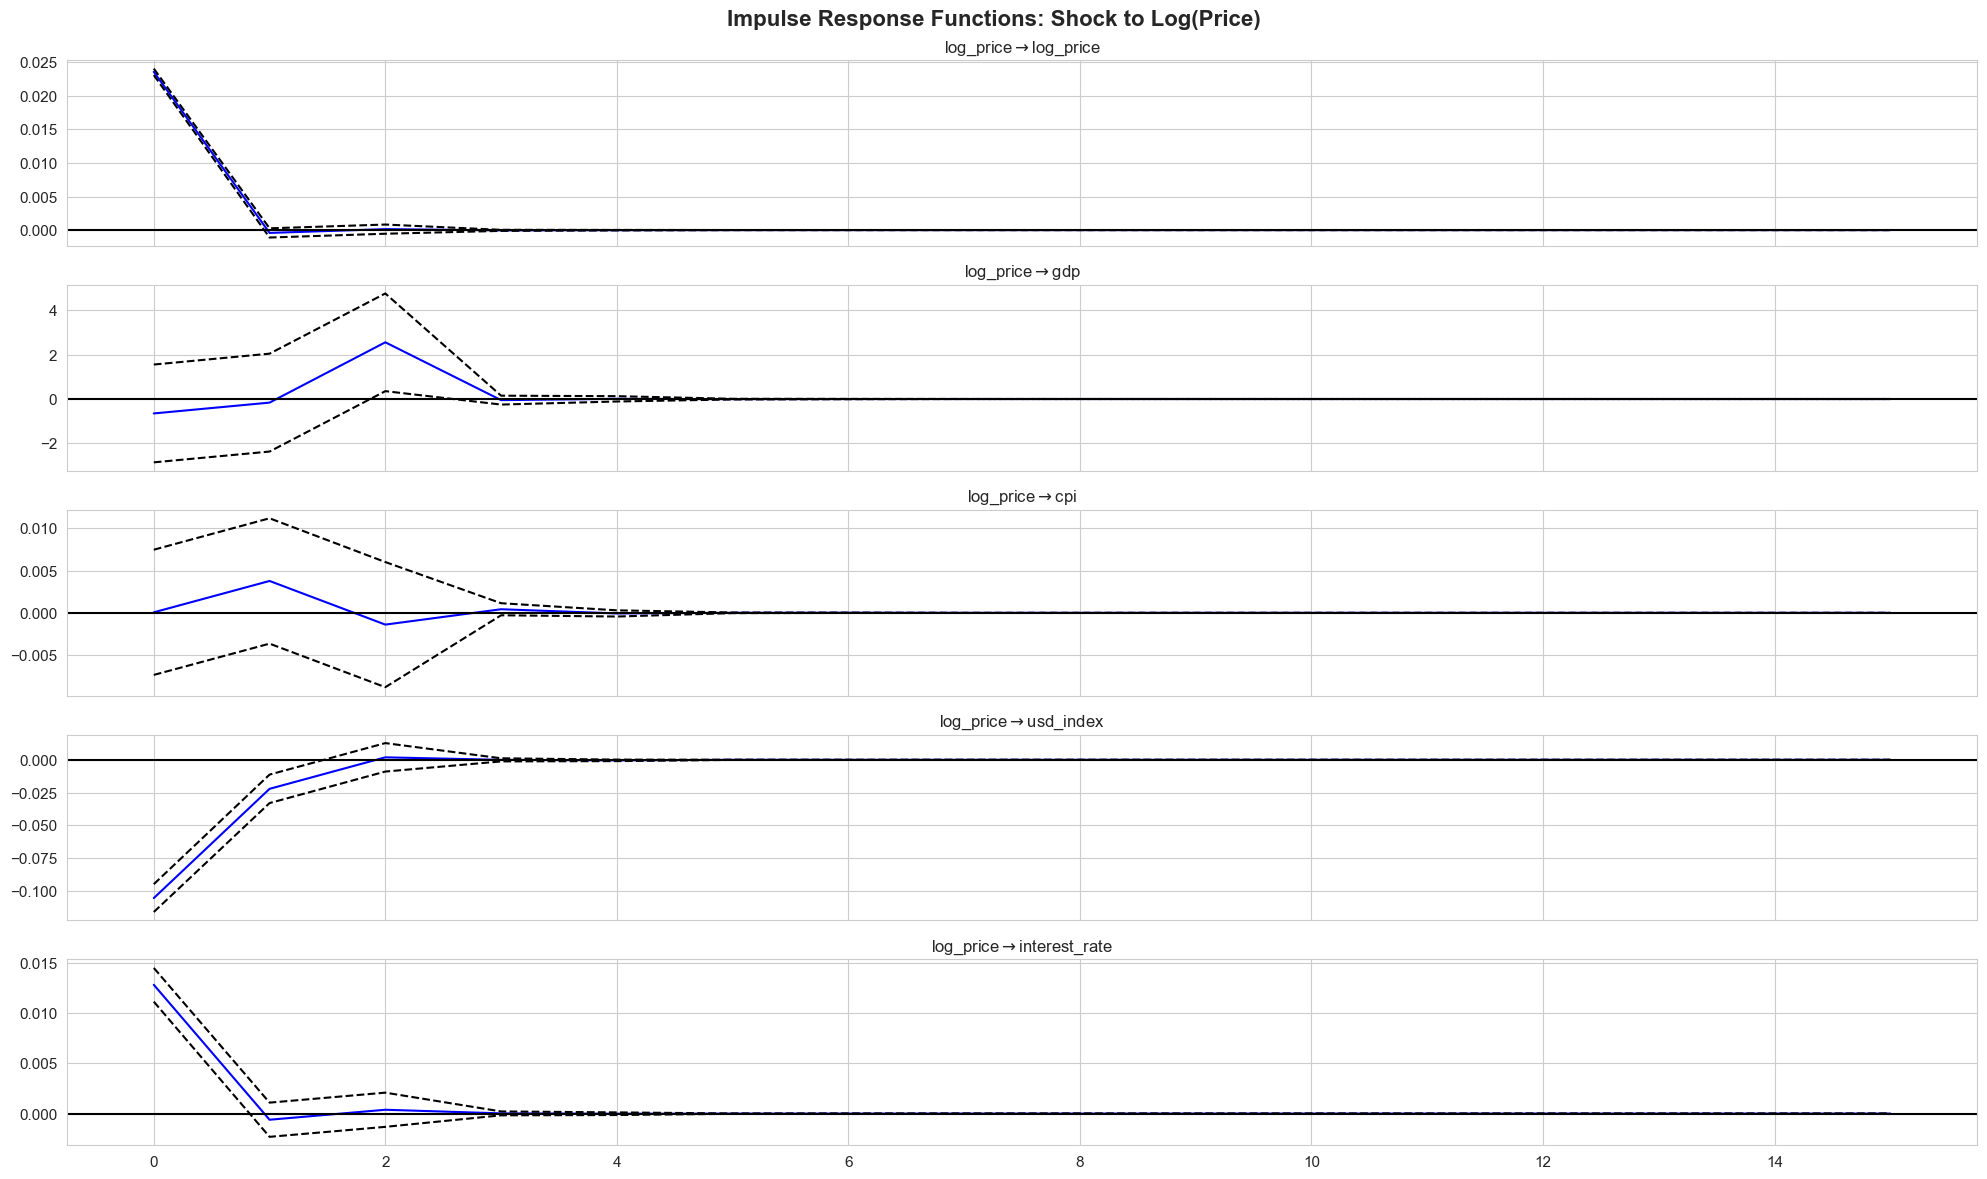

✅ Plot saved: var_irf_price_shock.png


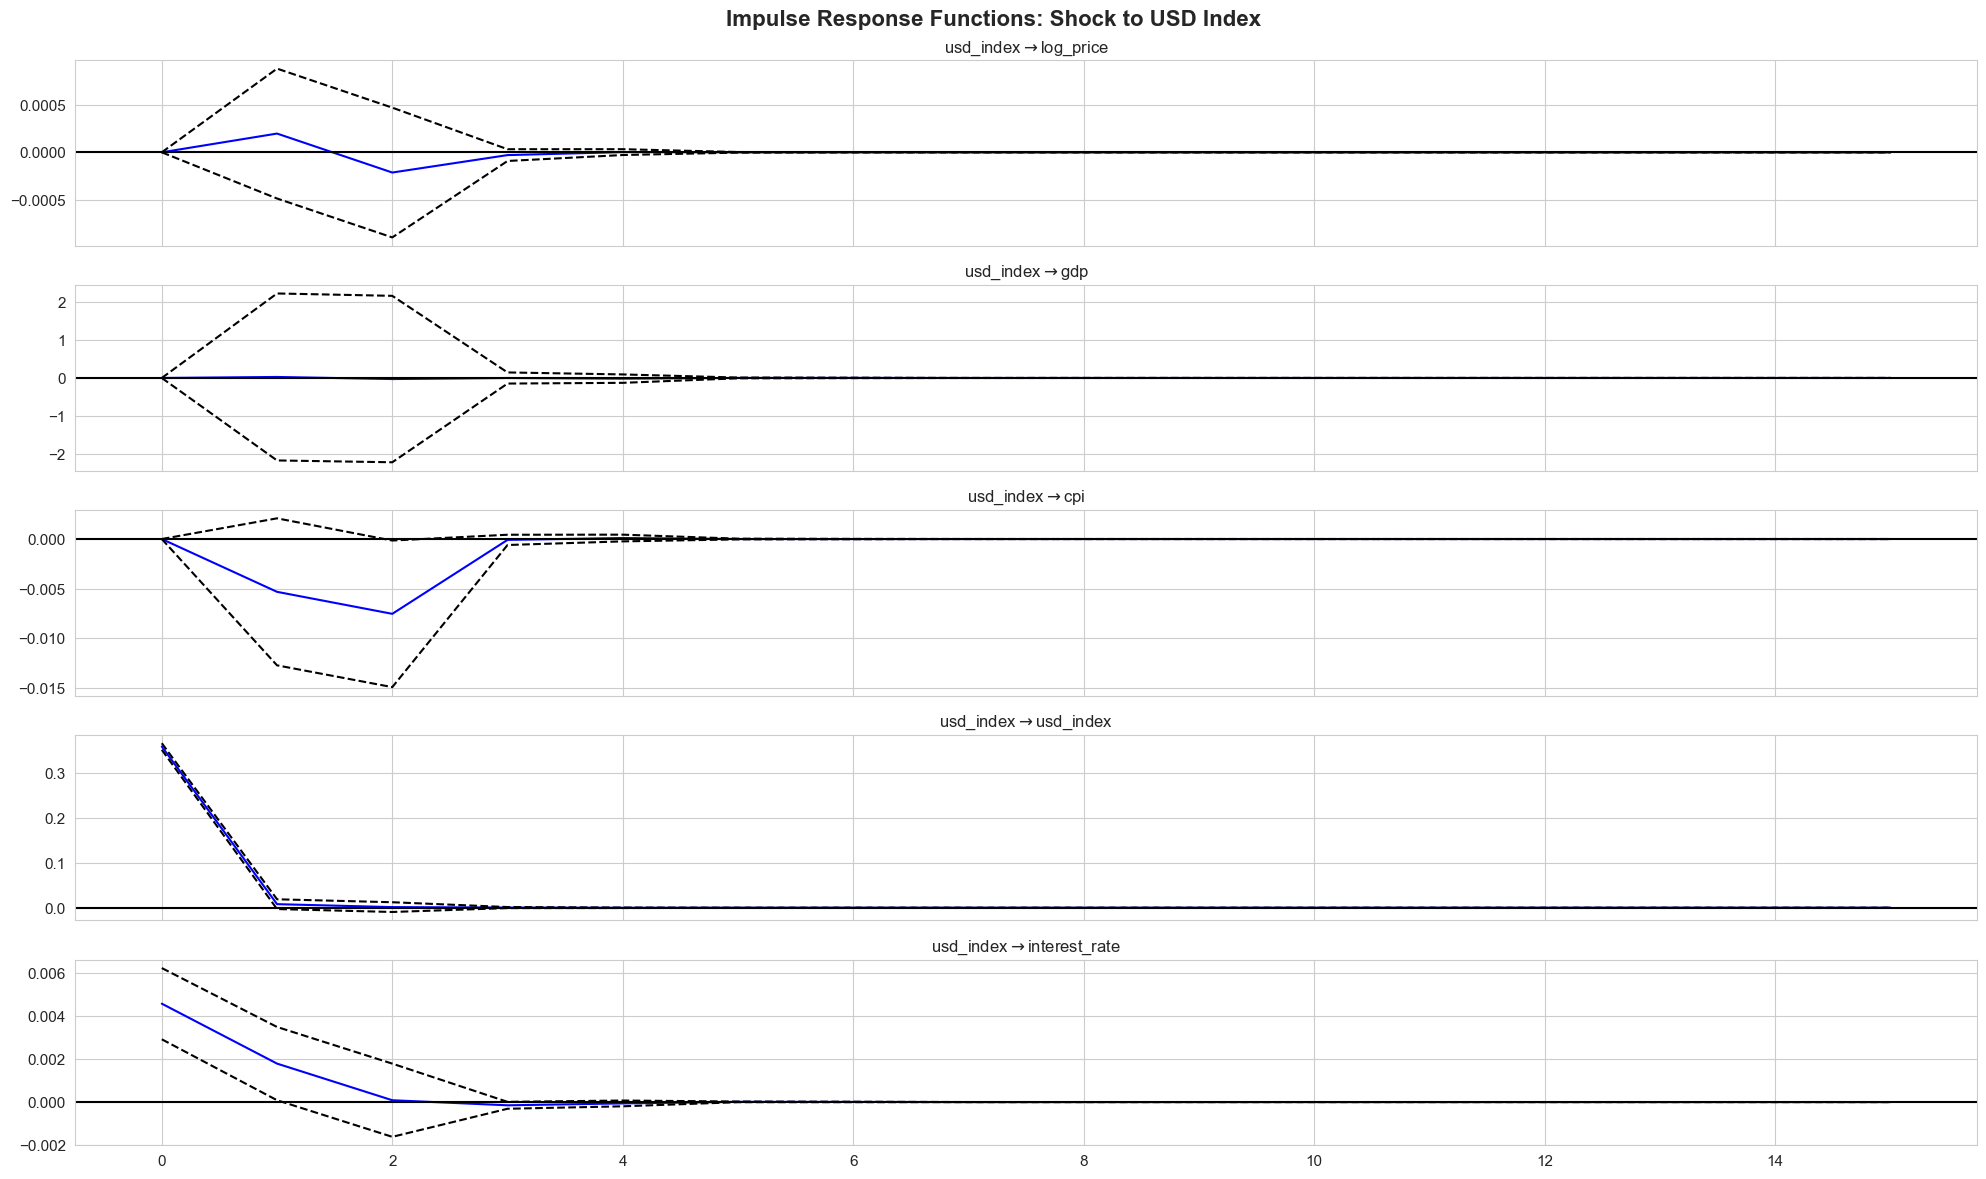

✅ Plot saved: var_irf_usd_shock.png


In [7]:
# Compute IRF
irf = var_model.irf(15)  # 15 periods ahead

# Plot IRF
fig = irf.plot(orth=True, impulse='log_price', figsize=(20, 12))
plt.suptitle('Impulse Response Functions: Shock to Log(Price)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/v2outputs/var_irf_price_shock.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: var_irf_price_shock.png")

# Plot IRF for USD shock
fig = irf.plot(orth=True, impulse='usd_index', figsize=(20, 12))
plt.suptitle('Impulse Response Functions: Shock to USD Index', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/v2outputs/var_irf_usd_shock.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: var_irf_usd_shock.png")

## 7️⃣ Forecast Error Variance Decomposition (FEVD)

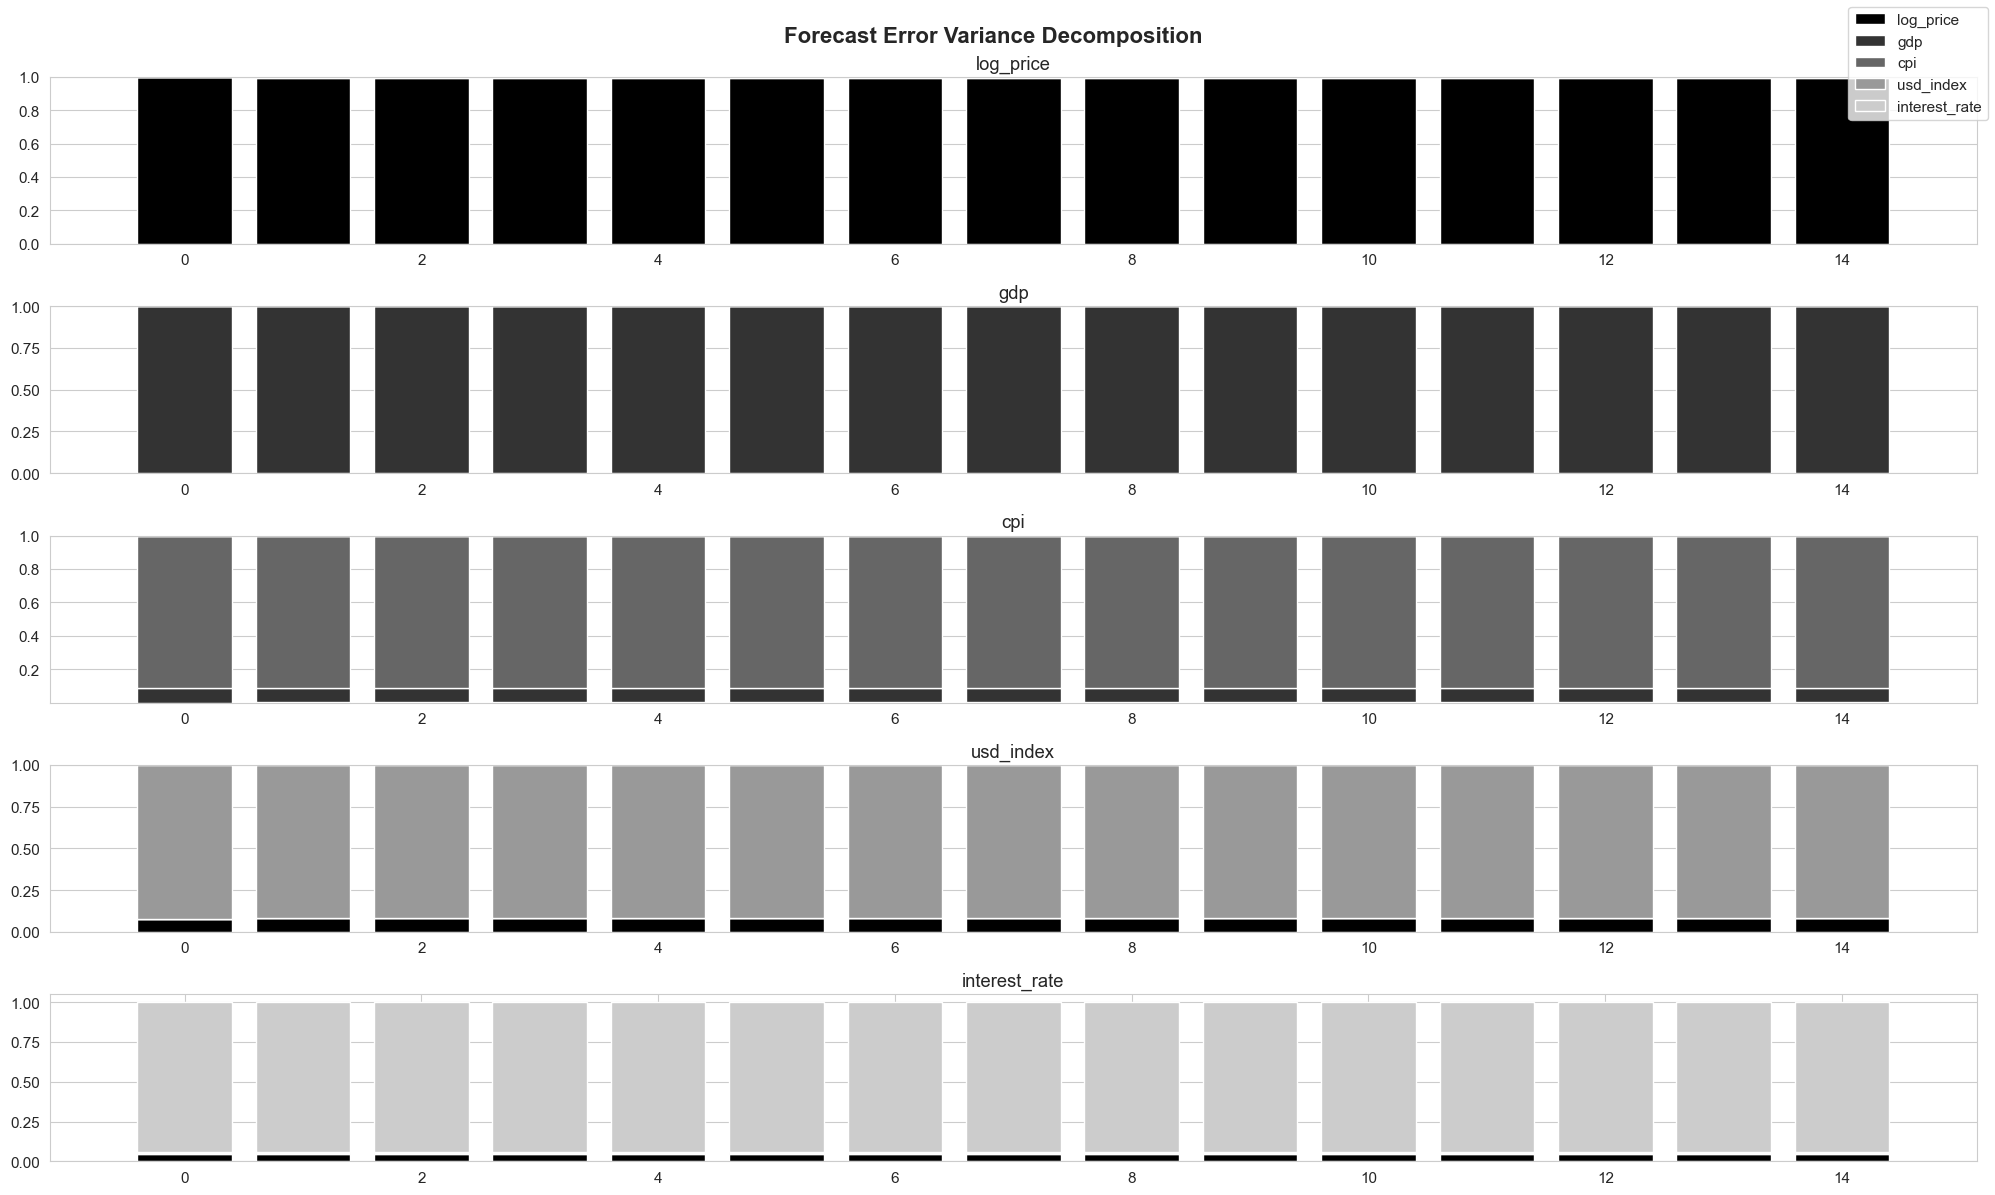

✅ Plot saved: var_fevd.png


In [8]:
# Compute FEVD
fevd = var_model.fevd(15)

# Plot FEVD
fig = fevd.plot(figsize=(20, 12))
plt.suptitle('Forecast Error Variance Decomposition', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/v2outputs/var_fevd.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: var_fevd.png")

## 8️⃣ Out-of-Sample Forecast

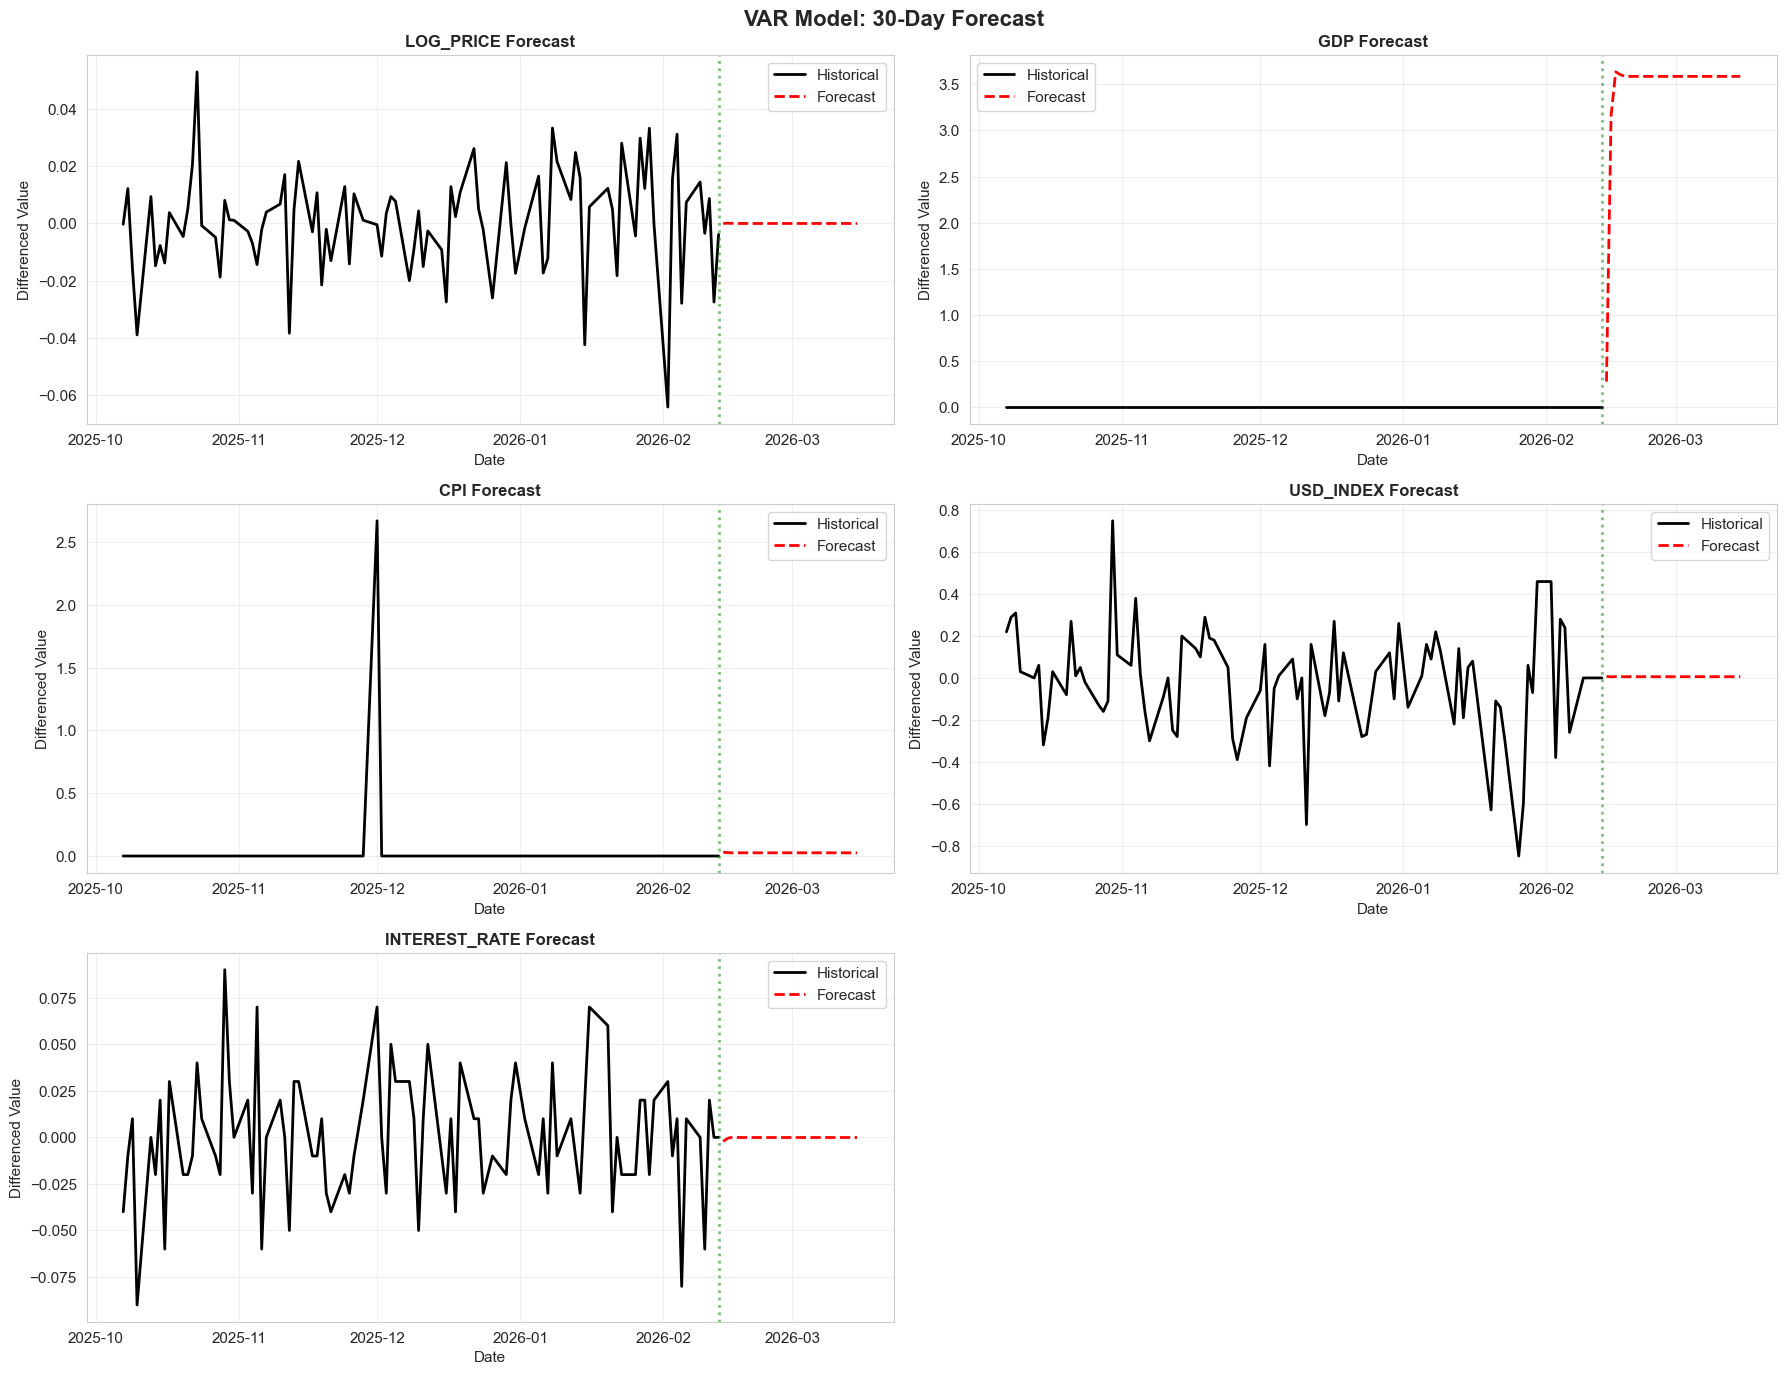

✅ Plot saved: var_forecast.png


In [9]:
# Forecast 30 days ahead
forecast_steps = 30
forecast = var_model.forecast(var_data_diff.values[-optimal_lag:], steps=forecast_steps)

# Create forecast dataframe
forecast_index = pd.date_range(
    start=var_data_diff.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq='D'
)
forecast_df = pd.DataFrame(
    forecast,
    index=forecast_index,
    columns=var_data_diff.columns
)

# Plot forecasts
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, col in enumerate(var_data_diff.columns):
    # Historical data (last 90 days)
    axes[idx].plot(var_data_diff[col].tail(90), 
                  color='black', linewidth=2, label='Historical')
    
    # Forecast
    axes[idx].plot(forecast_df[col], 
                  color='red', linewidth=2, linestyle='--', label='Forecast')
    
    axes[idx].set_title(f'{col.upper()} Forecast', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Differenced Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axvline(var_data_diff.index[-1], color='green', 
                     linestyle=':', linewidth=2, alpha=0.5)

# Hide unused subplot
axes[-1].axis('off')

plt.suptitle('VAR Model: 30-Day Forecast', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/v2outputs/var_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: var_forecast.png")

## 9️⃣ Residuals Diagnostics

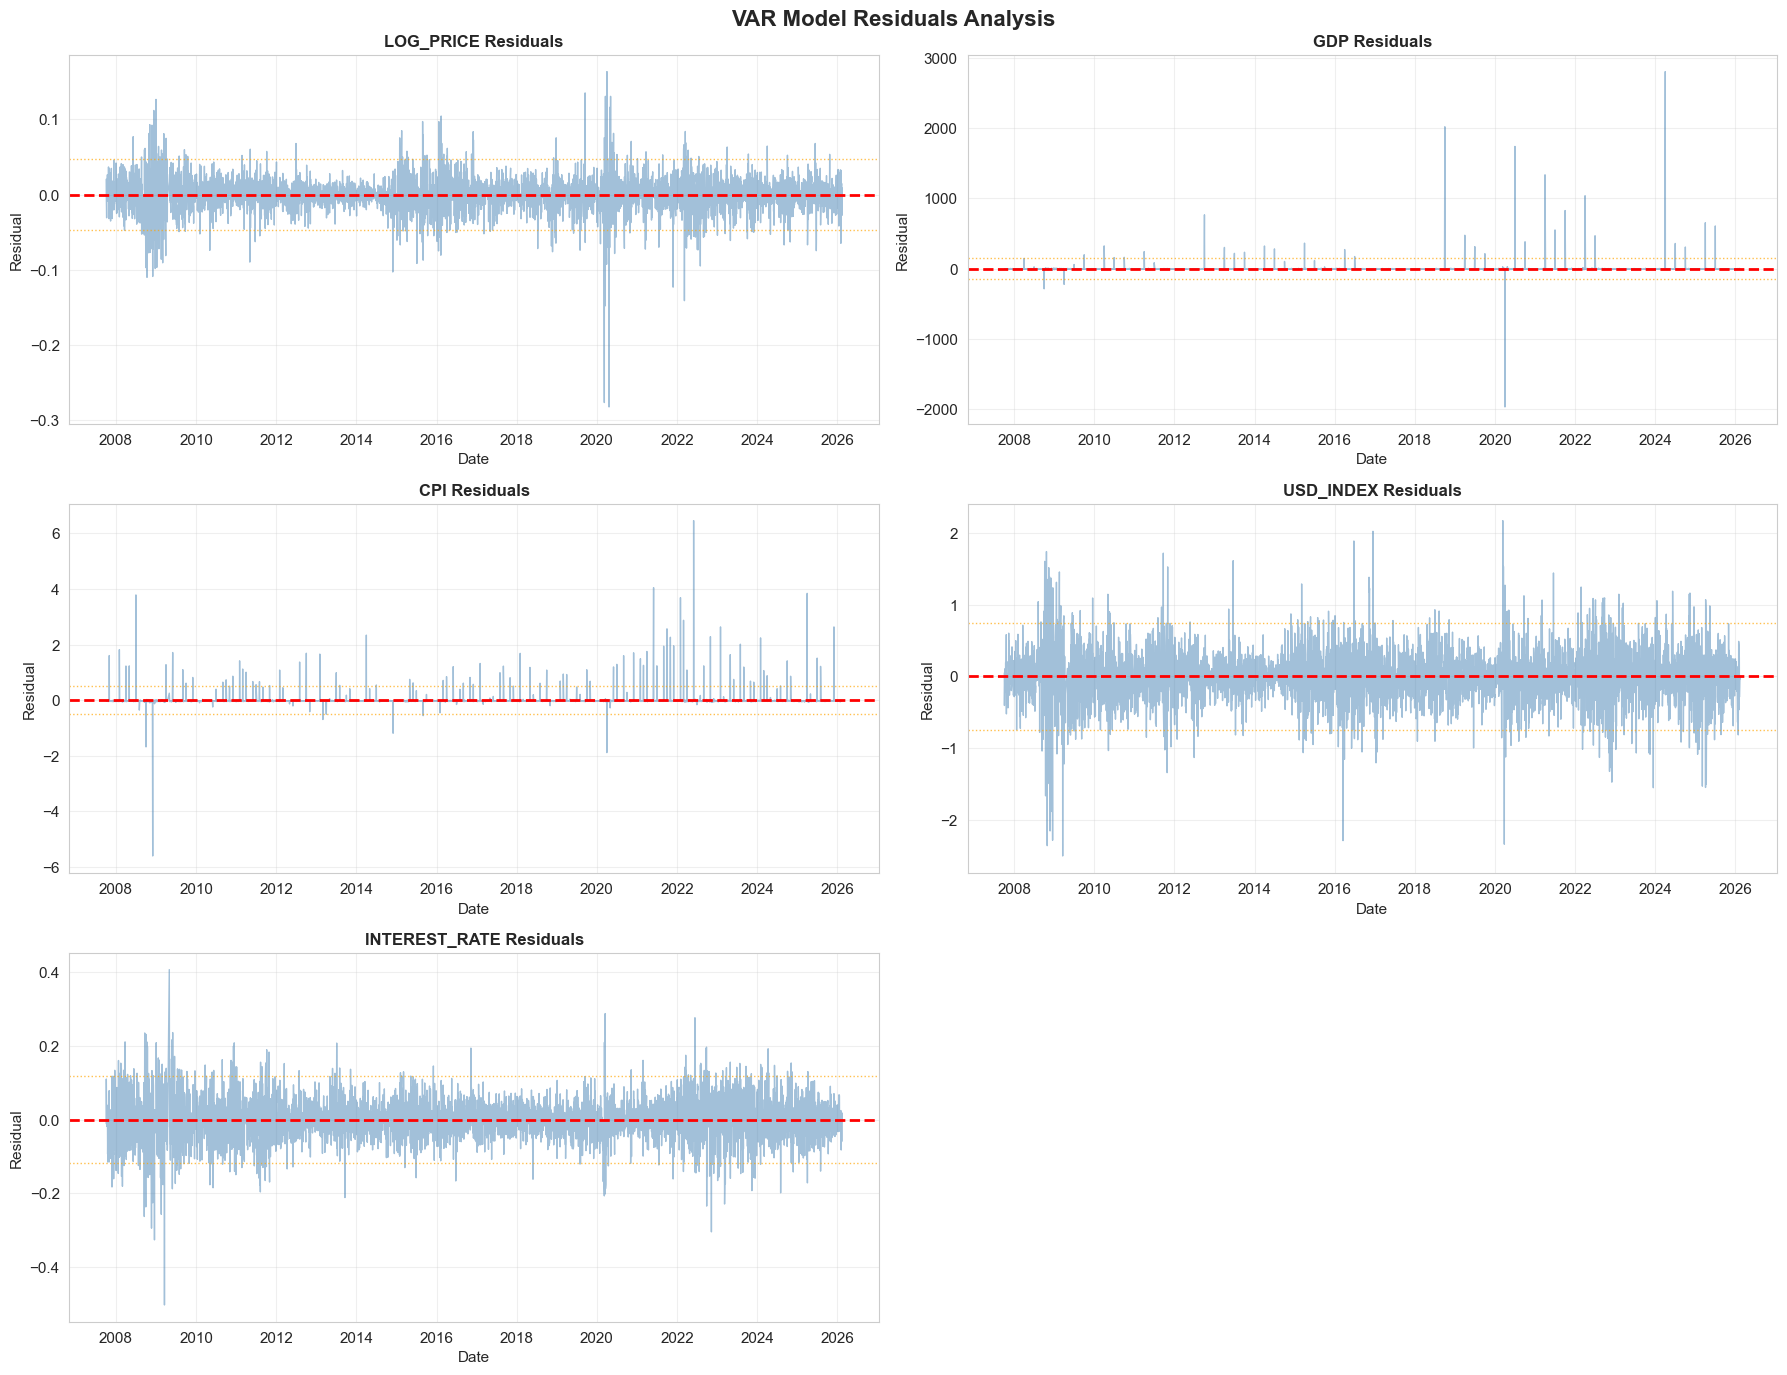

✅ Plot saved: var_residuals.png


In [10]:
# Get residuals
residuals = pd.DataFrame(
    var_model.resid,
    index=var_data_diff.index[optimal_lag:],
    columns=var_data_diff.columns
)

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, col in enumerate(residuals.columns):
    # Residual plot
    axes[idx].plot(residuals.index, residuals[col], 
                  color='steelblue', alpha=0.5, linewidth=1)
    axes[idx].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_title(f'{col.upper()} Residuals', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Residual')
    axes[idx].grid(True, alpha=0.3)
    
    # Add standard deviation bands
    std = residuals[col].std()
    axes[idx].axhline(2*std, color='orange', linestyle=':', linewidth=1, alpha=0.7)
    axes[idx].axhline(-2*std, color='orange', linestyle=':', linewidth=1, alpha=0.7)

# Hide unused subplot
axes[-1].axis('off')

plt.suptitle('VAR Model Residuals Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/v2outputs/var_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: var_residuals.png")

## ✅ VAR Analysis Complete!

**Generated files:**
1. `var_irf_price_shock.png` - IRF for oil price shock
2. `var_irf_usd_shock.png` - IRF for USD index shock
3. `var_fevd.png` - Forecast error variance decomposition
4. `var_forecast.png` - 30-day ahead forecasts
5. `var_residuals.png` - Residuals diagnostic plots

**Key Findings:**
- VAR captures interdependencies between oil and macro variables
- Granger causality reveals which variables predict others
- IRF shows how shocks propagate through the system
- FEVD quantifies each variable's contribution to forecast variance